In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
# import skimage
img = cv2.imread("pic.jpg")
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

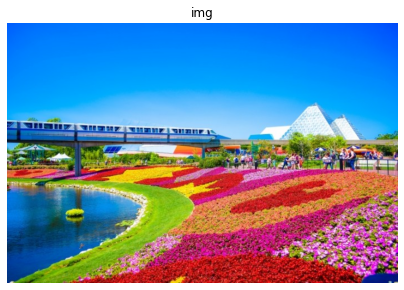

In [3]:
draw_picture(img, "img")

In [4]:
bl, gr, rd = cv2.split(img)

In [5]:
# складываем в одномерный массв троек
i_r = img.reshape((700*466, 3))

In [6]:
# восстанавливаем в рисунок
i_r_r = i_r.reshape((466,700, 3))

In [7]:
type(i_r[0][0])

numpy.uint8

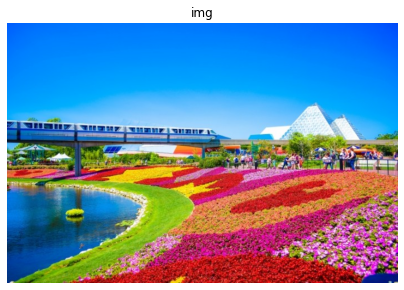

In [8]:
draw_picture(i_r_r, "img")

In [9]:
len(img[0])

700

In [10]:
# Исходное число цветов
df_test = pd.DataFrame(i_r,dtype=np.short)
df_test.drop_duplicates(inplace = True, ignore_index=True)
df_test

,0,1,2
0,255,92,0
1,253,93,0
2,254,94,0
3,255,96,0
4,253,96,0
...,...,...,...
164126,159,203,196
164127,166,207,200
164128,172,213,205
164129,175,213,201


In [11]:
# db = DBSCAN(eps=1, min_samples=100).fit(i_r)
# число кластеров
# df_dbscan = pd.DataFrame(i_r[db.core_sample_indices_])
# print(len(df_dbscan.drop_duplicates()))
# число "шумовых"
# print(len(db.labels_[np.where(db.labels_ == -1)]))

In [12]:
# clustering = AgglomerativeClustering(linkage="single", n_clusters=10) # только на single и работает:
# # https://github.com/scikit-learn/scikit-learn/issues/17960
# clustering.fit(i_r)

In [13]:
setup = [
{
    'alg':'KMeans',    'n_clusters':2,},
{
    'alg':'KMeans',    'n_clusters':5,},
{
    'alg':'KMeans',    'n_clusters':10,},
{
    'alg':'KMeans',    'n_clusters':20,},
{
    # не работает на больших эпсилон, т.к. считает матрицу расстояний и падает по памяти
    'alg':'DBSCAN',    'eps':1,   'min_samples':100}, 
{
    'alg':'AgglomerativeClustering',    'n_clusters':2,},
{
    'alg':'AgglomerativeClustering',    'n_clusters':5,},
{
    'alg':'AgglomerativeClustering',    'n_clusters':10,},
{
    'alg':'AgglomerativeClustering',    'n_clusters':20,},
]

In [14]:
def run(stp,data):
    res = stp
    for i,d in enumerate(stp):
        if d['alg']=='KMeans':
            kmeans = KMeans(n_clusters=d['n_clusters'], random_state=0).fit(data)
            res[i]['num_clusters'] = len(kmeans.cluster_centers_)
        if d['alg']=='DBSCAN':
            db = DBSCAN(eps=d['eps'], min_samples=d['min_samples']).fit(data)
            df_dbscan = pd.DataFrame(data[db.core_sample_indices_])
            # число кластеров
            # print(len(df_dbscan.drop_duplicates()))
            # число "шумовых"
            # print(len(db.labels_[np.where(db.labels_ == -1)]))
            res[i]['num_clusters'] = len(df_dbscan.drop_duplicates())
        if d['alg']=='AgglomerativeClustering':
            agl = AgglomerativeClustering(linkage="ward", n_clusters=d['n_clusters']).fit(data)
            res[i]['num_clusters'] = agl.n_clusters_
        
    return res

# run(setup,img[0])

[[ 64.  37. 181.]
 [254. 144.   2.]
 [220. 186. 170.]
 [104.  75.  31.]
 [ 54. 155. 170.]]
cntr = [ 64.  37. 181.]
cntr_idx = 153603
color = [ 64  37 181]
54793
cntr = [254. 144.   2.]
cntr_idx = 0
color = [254 144   2]
121566
cntr = [220. 186. 170.]
cntr_idx = 98946
color = [220 186 170]
46821
cntr = [104.  75.  31.]
cntr_idx = 118899
color = [104  75  31]
41040
cntr = [ 54. 155. 170.]
cntr_idx = 119786
color = [ 54 155 170]
61980


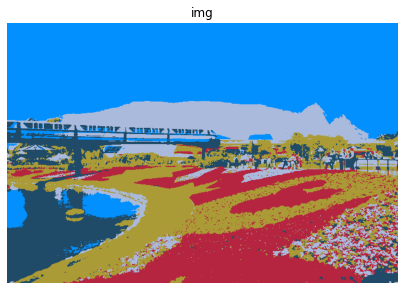

In [16]:
# складываем в одномерный массв троек
i_r = img.reshape((700*466, 3))
kmeans = KMeans(n_clusters=5, random_state=0).fit(i_r)
# len(kmeans.cluster_centers_)
df = pd.DataFrame(i_r)
a = i_r
print(kmeans.cluster_centers_)
for idx, cntr in enumerate(kmeans.cluster_centers_): 
    # a0 = cntr
    cntr_idx = np.sum(np.square(np.abs(a-cntr)),1).argmin()
    cntr_color = a[cntr_idx]
    print('cntr = %s' % (str(cntr)))
    print('cntr_idx = %s' % (str(cntr_idx)))
    print('color = %s' % (str(cntr_color)))
    df.loc[kmeans.labels_== idx, :] = cntr_color
    print(len(df.loc[kmeans.labels_== idx, :]))
draw_picture(df.to_numpy().reshape((466,700, 3)), "img")
